# Graph Classification on MUTAG (Molecules)

### Author: Nimish Sanghi https://github.com/nsanghi

In this notebook we will use [JAX](https://github.com/google/jax), [Haiku](https://dm-haiku.readthedocs.io/en/latest/), [Optax](https://optax.readthedocs.io/en/latest/) and [Jraph](https://jraph.readthedocs.io/en/latest/)

You can read through [Node Classification notebook](https://github.com/probml/pyprobml/blob/master/notebooks/book1/23/gnn_node_classification_jraph.ipynb) for the details each of the above libraries and how they work together to train GNN models.

We will continue further in this notebook and focus on a complete Graph Classification model for MUTAG. 

This notebook is based on:
https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb

The main difference from our previous setup is that instead of observing individual node latents, we are now attempting to summarize them into one embedding vector, representative of the entire graph, which we then use to predict the class of this graph.

We will do this on one of the most common tasks of this type -- **molecular property prediction**, where molecules are represented as graphs. Nodes correspond to atoms, and edges represent the bonds between them.

We will use the **MUTAG** dataset for this example, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection.

Authers of the notebook at Deepmind have converted this dataset to be compatible with jraph and we will download it in the cells below.

Citation for TUDatasets: [Morris, Christopher, et al. Tudataset: A collection of benchmark datasets for learning with graphs. arXiv preprint arXiv:2007.08663. 2020.](https://chrsmrrs.github.io/datasets/)



## Setup: Install and Import libraries

In [1]:
# Imports
%matplotlib inline
import functools
from typing import Any, Callable, Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import pickle
import jax
import jax.numpy as jnp
import jax.tree_util as tree

try:
    import jraph
except ModuleNotFoundError:
    %pip install -qq -U git+https://github.com/deepmind/jraph.git
    import jraph

try:
    import haiku as hk
except ModuleNotFoundError:
    %pip install -qq -U dm-haiku
    import haiku as hk

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq -U optax
    import optax

try:
    import networkx as nx
except ModuleNotFoundError:
    %pip install -qq -U networkx
    import networkx as nx

     |████████████████████████████████| 309 kB 8.2 MB/s 
     |████████████████████████████████| 140 kB 8.1 MB/s 
     |████████████████████████████████| 72 kB 735 kB/s 


## Representing a Graph in jraph

In jraph, a graph is represented with a `GraphsTuple` object. In addition to defining the graph structure of nodes and edges, you can also store node features, edge features and global graph features in a `GraphsTuple`.

In the `GraphsTuple`, edges are represented in two aligned arrays of node indices: senders (source nodes) and receivers (destinaton nodes).
Each index corresponds to one edge, e.g. edge `i` goes from `senders[i]` to `receivers[i]`.

Let us now download the jraph version of MUTAG

In [2]:
# Download jraph version of MUTAG.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
with open("/tmp/mutag.pickle", "rb") as f:
    mutag_ds = pickle.load(f)

--2022-06-30 11:25:01--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352981 (345K) [application/octet-stream]
Saving to: ‘/tmp/mutag.pickle’

mutag.pickle        100%[===================>] 344.71K  --.-KB/s    in 0.002s  

2022-06-30 11:25:01 (145 MB/s) - ‘/tmp/mutag.pickle’ saved [352981/352981]



#### Visualizing the Graph
To visualize the graph structure, we will use the [`networkx`](networkx.org) library because it already has functions for drawing graphs.

We first convert the `jraph.GraphsTuple` to a `networkx.DiGraph`.

In [3]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
    nodes, edges, receivers, senders, _, _, _ = jraph_graph
    nx_graph = nx.DiGraph()
    if nodes is None:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n)
    else:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n, node_feature=nodes[n])
    if edges is None:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(int(senders[e]), int(receivers[e]))
    else:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(int(senders[e]), int(receivers[e]), edge_feature=edges[e])
    return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
    nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, font_color="yellow")

The dataset is saved as a list of examples, each example is a dictionary containing an input_graph and its corresponding target.

In [4]:
# number of graphs in the dataset
print(f"Number of graphs in the dataset: {len(mutag_ds)}")

# Inspect the first graph
print("\nInspecting the first graph:")
g = mutag_ds[0]["input_graph"]
print(f"Number of nodes: {g.n_node[0]}")
print(f"Number of edges: {g.n_edge[0]}")
print(f"Node features shape: {g.nodes.shape}")
print(f"Edge features shape: {g.edges.shape}")

Number of graphs in the dataset: 188

Inspecting the first graph:
Number of nodes: 17
Number of edges: 38
Node features shape: (17, 7)
Edge features shape: (38, 4)


Let us see first graph:

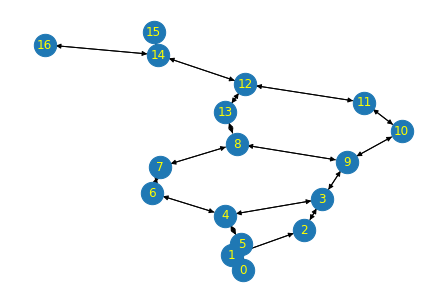

In [5]:
draw_jraph_graph_structure(g)

We see that there are 188 graphs, to be classified in one of 2 classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features (`edge_attr`) represent the bond type, which we will here ignore.

Let's split the dataset to use the first 150 graphs as the training set (and the rest as the test set).

In [6]:
train_mutag_ds = mutag_ds[:150]
test_mutag_ds = mutag_ds[150:]

In [7]:
train_mutag_ds[0]["input_graph"].n_node.shape

(1,)

#### Padding Graphs to Speed Up Training

Since jax recompiles the program for each graph size, training would take a long time due to recompilation for different graph sizes. To address that, we pad the number of nodes and edges in the graphs to nearest power of two. Since jax maintains a cache
of compiled programs, the compilation cost is amortized.

In [8]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def _nearest_bigger_power_of_two(x: int) -> int:
    """Computes the nearest power of two greater than x for padding."""
    y = 2
    while y < x:
        y *= 2
    return y


def pad_graph_to_nearest_power_of_two(graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Pads a batched `GraphsTuple` to the nearest power of two.
    For example, if a `GraphsTuple` has 7 nodes, 5 edges and 3 graphs, this method
    would pad the `GraphsTuple` nodes and edges:
      7 nodes --> 8 nodes (2^3)
      5 edges --> 8 edges (2^3)
    And since padding is accomplished using `jraph.pad_with_graphs`, an extra
    graph and node is added:
      8 nodes --> 9 nodes
      3 graphs --> 4 graphs
    Args:
      graphs_tuple: a batched `GraphsTuple` (can be batch size 1).
    Returns:
      A graphs_tuple batched to the nearest power of two.
    """
    # Add 1 since we need at least one padding node for pad_with_graphs.
    pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_node)) + 1
    pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_edge))
    # Add 1 since we need at least one padding graph for pad_with_graphs.
    # We do not pad to nearest power of two because the batch size is fixed.
    pad_graphs_to = graphs_tuple.n_node.shape[0] + 1
    return jraph.pad_with_graphs(graphs_tuple, pad_nodes_to, pad_edges_to, pad_graphs_to)

#### Graph Network Model Definition

We will use [`jraph.GraphNetwork()`](https://jraph.readthedocs.io/en/latest/api.html#jraph.GraphNetwork) to build our graph model. The `GraphNetwork` architecture is defined in [Battaglia et al. (2018)](https://arxiv.org/pdf/1806.01261.pdf). This function requires following parameters:
```
update_edge_fn – function used to update the edges or None to deactivate edge updates.

update_node_fn - function used to update the nodes or None to deactivate node updates.

update_global_fn - function used to update the globals or None to deactivate globals updates. Default is None.

aggregate_edges_for_nodes_fn - function used to aggregate messages to each node. Default is <function segment_sum>.

aggregate_nodes_for_globals_fn - function used to aggregate the nodes for the globals. Default is <function segment_sum>.

aggregate_edges_for_globals_fn - function used to aggregate the edges for the globals. Default is <function segment_sum>.

attention_logit_fn - function used to calculate the attention weights or None to deactivate attention mechanism. Default is None.

attention_normalize_fn - function used to normalize raw attention logits or None if attention mechanism is not active.  Default is <function segment_softmax>.

attention_reduce_fn - function used to apply weights to the edge features or None if attention mechanism is not active.  Default is None.
```

We first define update functions for nodes, edges, and the full graph (global). We will use MLP blocks for all three.

In [9]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
@jraph.concatenated_args
def edge_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
    """Edge update function for graph net."""
    net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(128)])
    return net(feats)


@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
    """Node update function for graph net."""
    net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(128)])
    return net(feats)


@jraph.concatenated_args
def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
    """Global update function for graph net."""
    # MUTAG is a binary classification task, so output pos neg logits.
    net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(2)])
    return net(feats)


def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    # Add a global paramater for graph classification.
    graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
    embedder = jraph.GraphMapFeatures(hk.Linear(128), hk.Linear(128), hk.Linear(128))
    net = jraph.GraphNetwork(
        update_node_fn=node_update_fn, update_edge_fn=edge_update_fn, update_global_fn=update_global_fn
    )
    return net(embedder(graph))

#### Loss and Accuracy Function
Define the classification cross-entropy loss and accuracy function.

In [10]:
def compute_loss(
    params: hk.Params, graph: jraph.GraphsTuple, label: jnp.ndarray, net: jraph.GraphsTuple
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Computes loss and accuracy."""
    pred_graph = net.apply(params, graph)
    preds = jax.nn.log_softmax(pred_graph.globals)
    targets = jax.nn.one_hot(label, 2)

    # Since we have an extra 'dummy' graph in our batch due to padding, we want
    # to mask out any loss associated with the dummy graph.
    # Since we padded with `pad_with_graphs` we can recover the mask by using
    # get_graph_padding_mask.
    mask = jraph.get_graph_padding_mask(pred_graph)

    # Cross entropy loss.
    loss = -jnp.mean(preds * targets * mask[:, None])

    # Accuracy taking into account the mask.
    accuracy = jnp.sum((jnp.argmax(pred_graph.globals, axis=1) == label) * mask) / jnp.sum(mask)
    return loss, accuracy

#### Training and Evaluation Functions

In [11]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def train(dataset: List[Dict[str, Any]], num_train_steps: int) -> hk.Params:
    """Training loop."""

    # Transform impure `net_fn` to pure functions with hk.transform.
    net = hk.without_apply_rng(hk.transform(net_fn))
    # Get a candidate graph and label to initialize the network.
    graph = dataset[0]["input_graph"]

    # Initialize the network.
    params = net.init(jax.random.PRNGKey(42), graph)
    # Initialize the optimizer.
    opt_init, opt_update = optax.adam(1e-4)
    opt_state = opt_init(params)

    compute_loss_fn = functools.partial(compute_loss, net=net)
    # We jit the computation of our loss, since this is the main computation.
    # Using jax.jit means that we will use a single accelerator. If you want
    # to use more than 1 accelerator, use jax.pmap. More information can be
    # found in the jax documentation.
    compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

    for idx in range(num_train_steps):
        graph = dataset[idx % len(dataset)]["input_graph"]
        label = dataset[idx % len(dataset)]["target"]
        # Jax will re-jit your graphnet every time a new graph shape is encountered.
        # In the limit, this means a new compilation every training step, which
        # will result in *extremely* slow training. To prevent this, pad each
        # batch of graphs to the nearest power of two. Since jax maintains a cache
        # of compiled programs, the compilation cost is amortized.
        graph = pad_graph_to_nearest_power_of_two(graph)

        # Since padding is implemented with pad_with_graphs, an extra graph has
        # been added to the batch, which means there should be an extra label.
        label = jnp.concatenate([label, jnp.array([0])])

        (loss, acc), grad = compute_loss_fn(params, graph, label)
        updates, opt_state = opt_update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        if idx % 50 == 0:
            print(f"step: {idx}, loss: {loss}, acc: {acc}")
    print("Training finished")
    return params

In [12]:
def evaluate(dataset: List[Dict[str, Any]], params: hk.Params) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Evaluation Script."""
    # Transform impure `net_fn` to pure functions with hk.transform.
    net = hk.without_apply_rng(hk.transform(net_fn))
    # Get a candidate graph and label to initialize the network.
    graph = dataset[0]["input_graph"]
    accumulated_loss = 0
    accumulated_accuracy = 0
    compute_loss_fn = jax.jit(functools.partial(compute_loss, net=net))
    for idx in range(len(dataset)):
        graph = dataset[idx]["input_graph"]
        label = dataset[idx]["target"]
        graph = pad_graph_to_nearest_power_of_two(graph)
        label = jnp.concatenate([label, jnp.array([0])])
        loss, acc = compute_loss_fn(params, graph, label)
        accumulated_accuracy += acc
        accumulated_loss += loss
        if idx % 100 == 0:
            print(f"Evaluated {idx + 1} graphs")
    print("Completed evaluation.")
    loss = accumulated_loss / idx
    accuracy = accumulated_accuracy / idx
    print(f"Eval loss: {loss}, accuracy {accuracy}")
    return loss, accuracy

In [13]:
params = train(train_mutag_ds, num_train_steps=500)

step: 0, loss: 0.2843891382217407, acc: 0.0
step: 50, loss: 0.0006321418331936002, acc: 1.0
step: 100, loss: 0.0013380241580307484, acc: 1.0
step: 150, loss: 0.04702797159552574, acc: 1.0
step: 200, loss: 0.041739627718925476, acc: 1.0
step: 250, loss: 0.0028245325665920973, acc: 1.0
step: 300, loss: 0.047925930470228195, acc: 1.0
step: 350, loss: 0.032259076833724976, acc: 1.0
step: 400, loss: 0.0030686105601489544, acc: 1.0
step: 450, loss: 0.036227963864803314, acc: 1.0
Training finished


In [14]:
evaluate(test_mutag_ds, params)

Evaluated 1 graphs
Completed evaluation.
Eval loss: 0.14461469650268555, accuracy 0.7567567229270935


(DeviceArray(0.1446147, dtype=float32), DeviceArray(0.7567567, dtype=float32))

##### We converge at ~76% test accuracy. The accuracy can be trained by further tuning or using a more complex networks inside the `net_fn`.